In [1]:
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0],False)
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import pyshearlab
import os
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sn
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [3]:
train_df = pd.read_csv("D:/notebooks/MNIST Dataset/mnist_train.csv")
train_df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_df = pd.read_csv('D:/notebooks/MNIST Dataset/mnist_test.csv')
test_df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X = train_df.iloc[:,1:]
Y = train_df.label
del train_df

In [6]:
X_test = test_df.iloc[:,1:]
Y_test = test_df.label
del test_df

In [7]:
Y.unique()


array([5, 0, 4, 1, 9, 2, 3, 6, 7, 8], dtype=int64)

In [8]:
#normalizing the data
X = X/255

In [9]:
X_test = X_test/255

In [10]:
X = np.array(X).reshape(-1,28,28,1)
X.shape

(60000, 28, 28, 1)

In [11]:
X_test = np.array(X_test).reshape(-1,28,28,1)
X_test.shape

(10000, 28, 28, 1)

In [12]:
num_classes = len(Y.unique())
num_classes

10

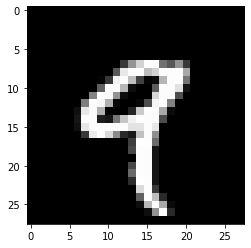

In [13]:
plt.imshow(X[4],cmap='gray')

Model Building

In [290]:
def data_aug(input):
    aug = tf.keras.layers.RandomRotation(0.1)(input)
    aug = tf.keras.layers.RandomZoom(0.1)(aug)
    #aug = tf.keras.layers.RandomCrop(0.1)(aug)
    return aug

In [299]:
def druidot(input_shape):
    input = tf.keras.layers.Input(shape=input_shape)
    aug = data_aug(input)
    x1 = tf.keras.layers.Conv2D(4,3,1,'same',activation='relu')(aug)
    x2 = tf.keras.layers.Conv2D(8,3,1,'same',activation='relu')(x1)
    x2 = tf.keras.layers.MaxPool2D(2,2,'valid')(x2)

    x1 = tf.keras.layers.Conv2D(16,3,1,'same',activation='relu')(x2)
    x2 = tf.keras.layers.Conv2D(32,3,1,'same',activation='relu')(x1)
    x2 = tf.keras.layers.MaxPool2D(2,2,'valid')(x2)
    x2 = tf.keras.layers.Add()([x2,tf.keras.layers.Conv2D(32,2,2,'valid')(x1)])
    #x2 = tf.keras.layers.Dropout(0.2)(x2)

    x1 = tf.keras.layers.Conv2D(64,3,1,'same',activation='relu')(x2)
    x2 = tf.keras.layers.Conv2D(128,3,1,'same',activation='relu')(x1)
    x2 = tf.keras.layers.MaxPool2D(2,2,'valid')(x2)

    output = tf.keras.layers.Flatten()(x2)
    #output = tf.keras.layers.Dense(64,activation='relu')(output)
    output = tf.keras.layers.Dense(32,activation='relu')(output)
    output = tf.keras.layers.Dense(num_classes,activation='softmax')(output)

    model = tf.keras.models.Model(inputs = input, outputs = output, name = 'druidot_model')
    
    return model

In [300]:
tf.keras.backend.clear_session()
Input_Shape = (28,28,1)
final_model = druidot(Input_Shape)

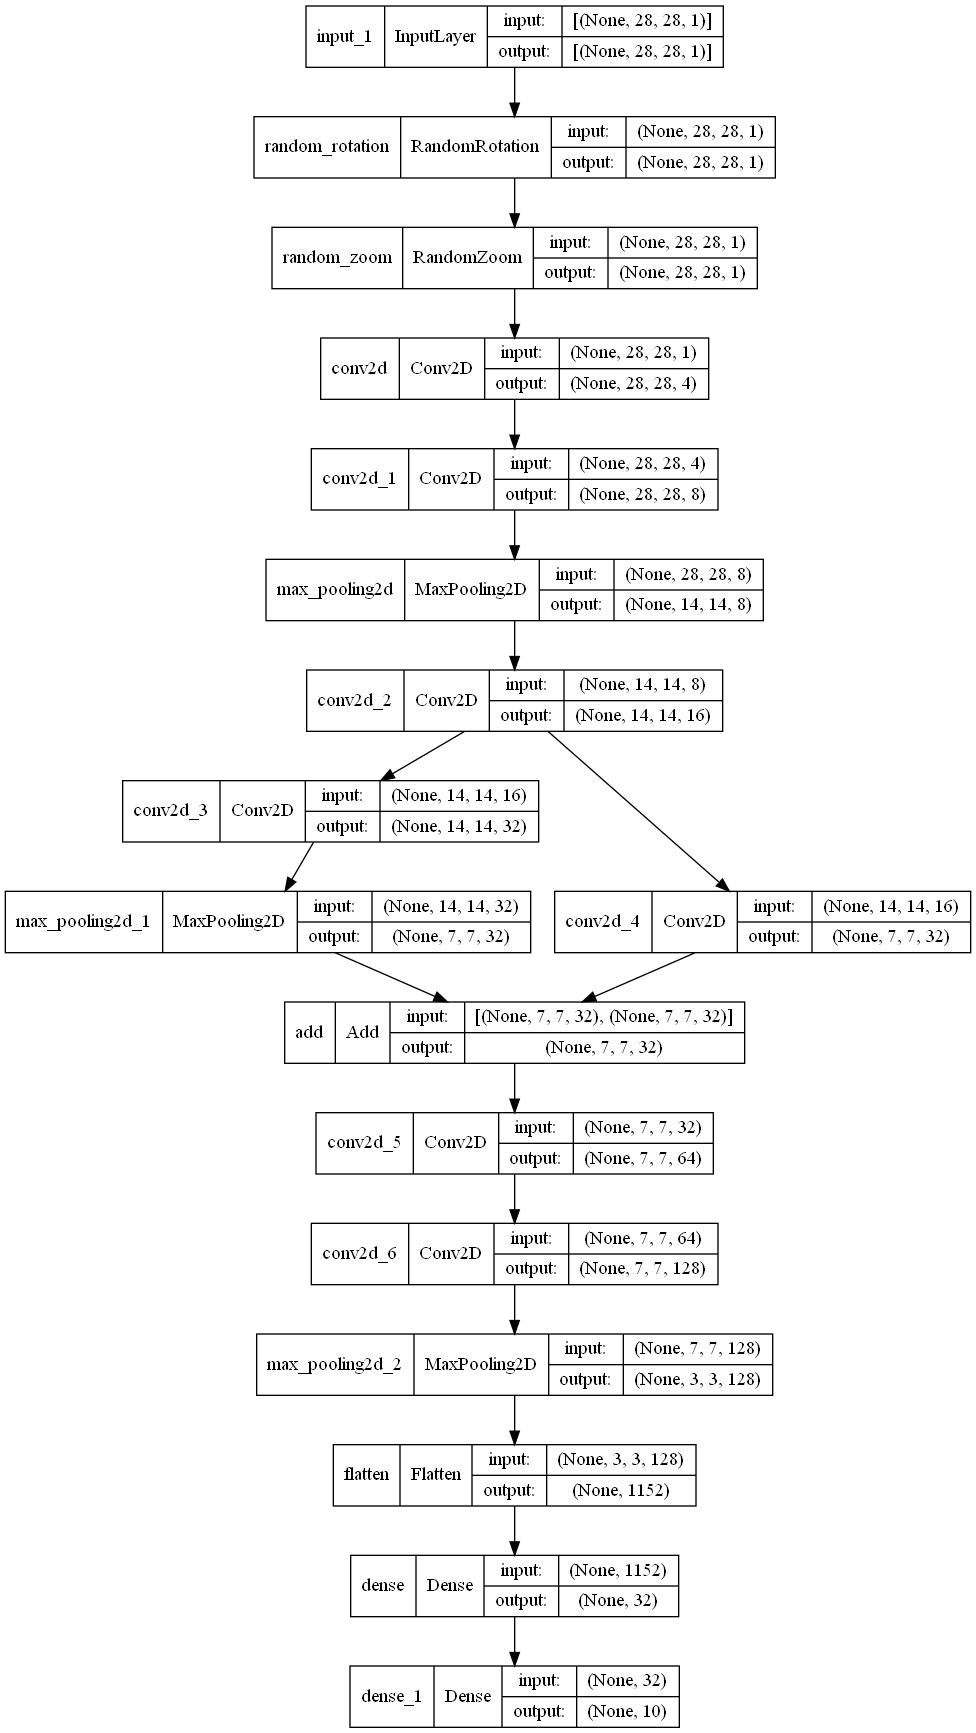

In [301]:
tf.keras.utils.plot_model(final_model,show_shapes=True)

In [81]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [303]:
final_model.compile(optimizer = tf.optimizers.Adam(), loss=tf.losses.SparseCategoricalCrossentropy(),metrics = ['accuracy'])

In [304]:
history = final_model.fit(x=X,y=Y, batch_size=32,epochs=50,validation_data=(X_test,Y_test),callbacks=[callbacks])

Epoch 1/50
1875/1875 [==============================] - 18s 9ms/step - loss: 0.2781 - accuracy: 0.9076 - val_loss: 0.0798 - val_accuracy: 0.9751
Epoch 2/50
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0863 - accuracy: 0.9731 - val_loss: 0.0476 - val_accuracy: 0.9854
Epoch 3/50
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0680 - accuracy: 0.9783 - val_loss: 0.0444 - val_accuracy: 0.9867
Epoch 4/50
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0565 - accuracy: 0.9827 - val_loss: 0.0350 - val_accuracy: 0.9899
Epoch 5/50
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0502 - accuracy: 0.9852 - val_loss: 0.0452 - val_accuracy: 0.9864
Epoch 6/50
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0455 - accuracy: 0.9858 - val_loss: 0.0385 - val_accuracy: 0.9888
Epoch 7/50
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0432 - accuracy: 0.9863 - val_loss: 0.0284 - val_

tf.keras.models.save_model(final_model,'D:/notebooks/MNIST Dataset/wrong7.hdf5')

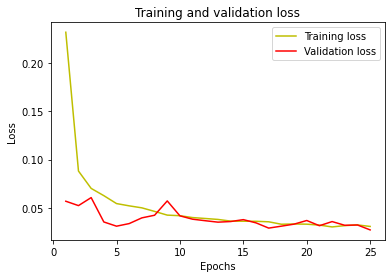

In [285]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.axis(True)
plt.show()

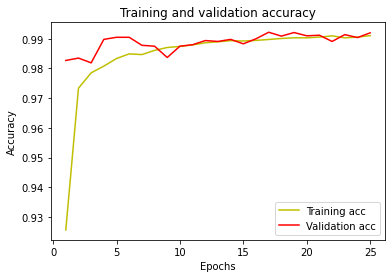

In [286]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)
plt.show()

In [180]:
final_model = tf.keras.models.load_model("D:/notebooks/MNIST Dataset/wrong7.hdf5")

In [181]:
tf.argmax(final_model.predict(X[4].reshape(-1,28,28,1))[0])

<tf.Tensor: shape=(), dtype=int64, numpy=9>

In [182]:
from itertools import groupby

def predict(image):
    image = Image.open(image).convert('L')
    width = image.size[0]
    height = image.size[1]
    ratio = width/height

    width = (int)(ratio*28)
    image = image.resize((width,28))
    image = np.array(image)
    image = 255-image
    image = image/255
    display(Image.fromarray((image*255).astype(np.uint8)))
    m = image.any(0)

    digits = [image[:,[*g]] for k,g in groupby(np.arange(len(m)), lambda x:m[x]!=0) if k]
    #for digit in digits:
        #display(Image.fromarray((digit*255).astype(np.uint8)))
    number = ""
    for i in range(len(digits)):
        digit = digits[i]
        w = digit.shape[1]
        filler = 28-w
        if(filler%2==0):
            out = np.concatenate((np.zeros((28,filler//2)),digit,np.zeros((28,filler//2))),axis=1)
        else:
            out = np.concatenate((np.zeros((28,filler//2+1)),digit,np.zeros((28,filler//2))),axis=1)

        number+=str((tf.argmax(final_model.predict(out.reshape(-1,28,28,1))[0])).numpy())
    print(number)

In [183]:
test_image = 'D:/notebooks/test.jpeg'
predict(test_image)

421941


Since 7 is the only digit which our model cannot recognize, we will train the model for 10 more instances of the digit "7"


In [205]:
final_model = tf.keras.models.load_model("D:/notebooks/MNIST Dataset/wrong7.hdf5")

In [206]:
import random

seed = 5

Y0 = list(Y[Y==0].index)
random.Random(seed).shuffle(Y0)
X0 = X[Y0[:500]]
Y1 = list(Y[Y==1].index)
random.Random(seed).shuffle(Y1)
X1 = X[Y1[:500]]
Y2 = list(Y[Y==2].index)
random.Random(seed).shuffle(Y2)
X2 = X[Y2[:500]]
Y3 = list(Y[Y==3].index)
random.Random(seed).shuffle(Y3)
X3 = X[Y3[:500]]
Y4 = list(Y[Y==4].index)
random.Random(seed).shuffle(Y4)
X4 = X[Y4[:500]]
Y5 = list(Y[Y==5].index)
random.Random(seed).shuffle(Y5)
X5 = X[Y5[:500]]
Y6 = list(Y[Y==6].index)
random.Random(seed).shuffle(Y6)
X6 = X[Y6[:500]]
Y7 = list(Y[Y==7].index)
random.Random(seed).shuffle(Y7)
X7 = X[Y7[:500]]
Y8 = list(Y[Y==8].index)
random.Random(seed).shuffle(Y8)
X8 = X[Y8[:500]]
Y9 = list(Y[Y==9].index)
random.Random(seed).shuffle(Y9)
X9 = X[Y9[:500]]

X_new = np.concatenate((X0,X1,X2,X3,X4,X5,X6,X7,X8,X9),axis=0)
Y_new = np.concatenate(([0 for _ in range(500)],[1 for _ in range(500)],[2 for _ in range(500)],[3 for _ in range(500)],[4 for _ in range(500)],[5 for _ in range(500)],[6 for _ in range(500)],[7 for _ in range(500)],[8 for _ in range(500)],[9 for _ in range(500)]),axis=0)

#random.Random(seed).shuffle(X_new)
#random.Random(seed).shuffle(Y_new)


In [207]:
history = final_model.fit(x=X_new,y=Y_new, batch_size=32,epochs=50,callbacks=[callbacks])

Epoch 1/50
157/157 [==============================] - 2s 11ms/step - loss: 0.0198 - accuracy: 0.9928
Epoch 2/50
157/157 [==============================] - 2s 11ms/step - loss: 0.0224 - accuracy: 0.9916
Epoch 3/50
157/157 [==============================] - 1s 9ms/step - loss: 0.0120 - accuracy: 0.9958
Epoch 4/50
157/157 [==============================] - 2s 10ms/step - loss: 0.0108 - accuracy: 0.9968
Epoch 5/50
157/157 [==============================] - 2s 10ms/step - loss: 0.0164 - accuracy: 0.9958
Epoch 6/50
157/157 [==============================] - 2s 10ms/step - loss: 0.0184 - accuracy: 0.9952
Epoch 7/50
157/157 [==============================] - 2s 10ms/step - loss: 0.0143 - accuracy: 0.9948


In [208]:
test_image = 'D:/notebooks/test.jpeg'
predict(test_image)

721941


tf.keras.models.save_model(final_model,"D:/notebooks/MNIST Dataset/correctModel.hdf5")

In [212]:
final_model = tf.keras.models.load_model("D:/notebooks/MNIST Dataset/correctModel.hdf5")
test_image = 'D:/notebooks/test.jpeg'
predict(test_image)

721941
